In [1]:
import findspark
findspark.init()
import pandas as pd

In [2]:
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as F

In [3]:
spark = (SparkSession.builder
.appName("gas_prices_esp")
.config("spark.sql.group_assignment.dir","hdfs://localhost:9000/raw/gas")
.getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
gasdf = spark.read \
             .option("inferSchema", "true") \
             .option("header", "true") \
             .parquet("hdfs://localhost:9000/datalake/raw/gas")
gasdf.createOrReplaceTempView("gas")

In [6]:
df_2020 = gasdf.filter((F.col('date') >= '2020-01-01'))

In [8]:
df_2020_gas = df_2020.select('date', 'gasoline_95E5', 'diesel_A')

In [9]:
import pyspark.sql.functions as f
df_year = df_2020_gas.withColumn('years',f.year(f.to_timestamp('date', 'yyyy/mm/dd')))

In [10]:
df_2020_gas.groupBy('years')

In [11]:
df_year.groupBy('years').avg('diesel_A').show()

+-----+---------------+
|years|  avg(diesel_A)|
+-----+---------------+
| 2022|1.6685254980000|
| 2020|1.0721183860000|
| 2021|1.2416919210000|
+-----+---------------+



In [12]:
df_year.groupBy('years').avg('gasoline_95E5').show()

+-----+------------------+
|years|avg(gasoline_95E5)|
+-----+------------------+
| 2022|   1.7221337380000|
| 2020|   1.1747384890000|
| 2021|   1.3730309860000|
+-----+------------------+



In [91]:
diesel_avg = df_2020_gas.groupBy('date').avg('diesel_A').sort('date')

type(diesel_avg)

pyspark.sql.dataframe.DataFrame

In [95]:
diesel_avg2 = diesel_avg.toPandas()

type(diesel_avg2)

pandas.core.frame.DataFrame

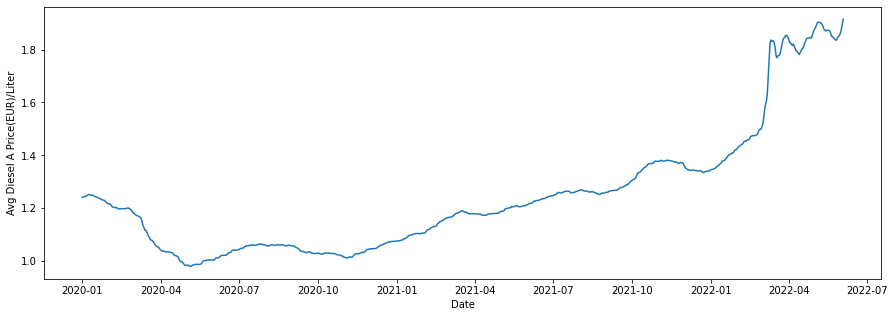

In [96]:
# slide 18
x = diesel_avg2["date"]
y = diesel_avg2["avg(diesel_A)"].astype('float')
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)
plt.xlabel('Date')
plt.ylabel('Avg Diesel A Price(EUR)/Liter')
plt.plot(x, y)
plt.show()

In [92]:
gas_avg = df_2020_gas.groupBy('date').avg('gasoline_95E5').sort('date')

gas_avg2 = gas_avg.toPandas()

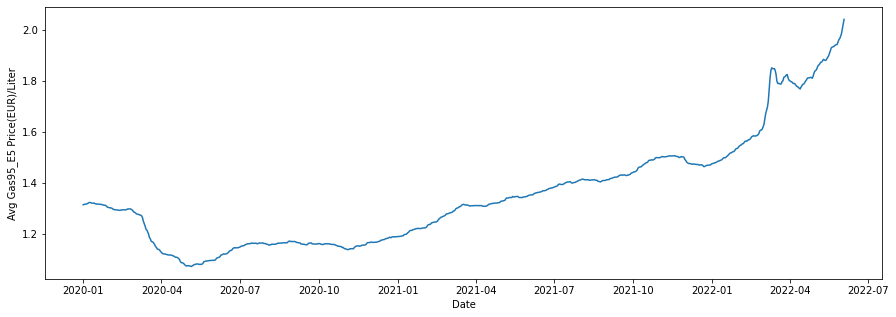

In [94]:
# slide 19
import matplotlib.pyplot as plt
x = gas_avg2["date"]
y = gas_avg2["avg(gasoline_95E5)"].astype('float')
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)
plt.xlabel('Date')
plt.ylabel('Avg Gas95_E5 Price(EUR)/Liter')
plt.plot(x, y)
plt.show()

In [21]:
gasdf = gasdf.filter((F.col('date') >= '2022-01-01'))

In [22]:
gasdf.registerTempTable("my_table")

In [23]:
spark.sql("""
SELECT count(distinct(station_id))
FROM my_table
WHERE diesel_A > 0.1 and gasoline_95E5 > 0.1
""").show()

+--------------------------+
|count(DISTINCT station_id)|
+--------------------------+
|                     10580|
+--------------------------+



In [24]:
top3_distributors ={}
top3_distributors_percentage ={}

In [29]:
#1 DISTRIBUTOR 
repsol = spark.sql("""
SELECT count(distinct(station_id))
FROM my_table
WHERE UPPER(name) LIKE '%REPSOL%'
""").collect()[0][0]

In [30]:
#2 DISTRIBUTOR 
cepsa = spark.sql("""
SELECT count(distinct(station_id))
FROM my_table
WHERE UPPER(name) LIKE '%CEPSA%'
""").collect()[0][0]

In [31]:
#3 DISTRIBUTOR 
bp = spark.sql("""
SELECT count(distinct(station_id))
FROM my_table
WHERE UPPER(name) LIKE '%BP%'
""").collect()[0][0]

In [32]:
#4 DISTRIBUTOR

spark.sql("""
SELECT count(distinct(station_id))
FROM my_table
WHERE UPPER(name) LIKE '%GALP%'
""").show()

+--------------------------+
|count(DISTINCT station_id)|
+--------------------------+
|                       538|
+--------------------------+



In [33]:
#TOTAL DISTRIBUTION

total = spark.sql("""
SELECT count(distinct(station_id))
FROM my_table
""").collect()[0][0]

In [34]:
top3_distributors.update({'repsol':repsol})

top3_distributors.update({'cepsa':cepsa})

top3_distributors.update({'bp':bp})

top3_distributors

{'repsol': 2819, 'cepsa': 1419, 'bp': 754}

In [35]:
top3_distributors_percentage.update({'repsol':repsol/total})

top3_distributors_percentage.update({'cepsa':cepsa/total})

top3_distributors_percentage.update({'bp':bp/total})

top3_distributors_percentage

{'repsol': 0.2524628336020061,
 'cepsa': 0.12708221386351423,
 'bp': 0.06752641948773061}

The percentages shares of the three biggest gas distributors are respectively:

           - 25% for Repsol
           - 13% for Cepsa
           - 7% for BP
           
            The sum the other providers accounts for 55% of the total transactions


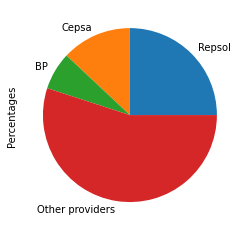

In [36]:
#slide 20
piechart = pd.DataFrame({'Percentages':[0.25,0.13,0.07,0.55]},
                        index=['Repsol','Cepsa','BP','Other providers'])

piechart.Percentages.plot.pie()
print(f"""The percentages shares of the three biggest gas distributors are respectively:

           - 25% for Repsol
           - 13% for Cepsa
           - 7% for BP
           
            The sum the other providers accounts for 55% of the total transactions""")

In [48]:
# creating macro areas
df_area = gasdf.withColumn("Area", 
            F.when(gasdf.region_name=="Comunidad Valenciana", "Mediterranean")\
.when(gasdf.region_name=="Madrid", "Center")\
.when(gasdf.region_name=="Rioja (La)", "Center")\
.when(gasdf.region_name=="Asturias", "North")\
.when(gasdf.region_name=="Aragón", "North")\
.when(gasdf.region_name=="Cantabria", "North")\
.when(gasdf.region_name=="Extremadura", "Center")\
.when(gasdf.region_name=="Galicia", "North")\
.when(gasdf.region_name=="Murcia", "Mediterranean")\
.when(gasdf.region_name=="Ceuta", "Other")\
.when(gasdf.region_name=="Andalucia", "Mediterranean")\
.when(gasdf.region_name=="Canarias", "Other")\
.when(gasdf.region_name=="Cataluña", "Mediterranean")\
.when(gasdf.region_name=="Navarra", "North")\
.when(gasdf.region_name=="Castilla y León", "Center")\
.when(gasdf.region_name=="País Vasco", "North")\
.when(gasdf.region_name=="Baleares", "Other")\
.when(gasdf.region_name=="Castilla la Mancha", "Center")\
.when(gasdf.region_name=="Melilla", "Other"))

In [50]:
df_area.registerTempTable("my_table2")

In [57]:
df_area.groupBy("Area").agg(F.countDistinct("station_id")).orderBy("Area").show()

+-------------+-----------------+
|         Area|count(station_id)|
+-------------+-----------------+
|       Center|             3056|
|Mediterranean|             5304|
|        North|             2119|
|        Other|              687|
+-------------+-----------------+



In [58]:
df_repsol = df_area.withColumn("Repsol", 
            F.when((df_area.name=="REPSOL") | (df_area.name=="repsol") | (df_area.name=="Repsol"),1)\
            .otherwise(0))

In [59]:
df_repsol.groupBy("Area", "Repsol").agg(F.countDistinct("station_id")).orderBy("Area").show()

+-------------+------+-----------------+
|         Area|Repsol|count(station_id)|
+-------------+------+-----------------+
|       Center|     1|              883|
|       Center|     0|             2173|
|Mediterranean|     0|             4133|
|Mediterranean|     1|             1171|
|        North|     0|             1547|
|        North|     1|              572|
|        Other|     0|              558|
|        Other|     1|              129|
+-------------+------+-----------------+



In [67]:
total_stations_Center = 3056
total_stations_Mediterranean = 5304
total_stations_North = 2119
total_stations_Other = 687
total_stations = total_stations_Center + total_stations_Mediterranean + total_stations_North+ total_stations_Other

Repsol_Center = 883
Repsol_Mediterranean = 1171
Repsol_North = 572
Repsol_Other = 129
Repsol_Total = Repsol_Center + Repsol_Mediterranean + Repsol_North + Repsol_Other

repsol_share = Repsol_Total/total_stations
repsol_share

0.24673114812824645

In [63]:
repsol_percentage = {}

repsol_percentage.update({'Center':Repsol_Center/total_stations_Center})

repsol_percentage.update({'Mediterranean':Repsol_Mediterranean/total_stations_Mediterranean})

repsol_percentage.update({'North':Repsol_North/total_stations_North})

repsol_percentage.update({'Other':Repsol_Other/total_stations_Other})

repsol_percentage

{'Center': 0.28893979057591623,
 'Mediterranean': 0.22077677224736048,
 'North': 0.26993865030674846,
 'Other': 0.18777292576419213}

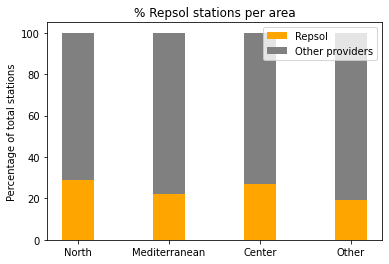

In [70]:
#slide 21

import matplotlib.pyplot as plt


labels = ['North', 'Mediterranean', 'Center', 'Other']
Repsol_stations = [29, 22, 27, 19]
Other_stations = [71, 78, 73, 81]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()


ax.bar(labels, Repsol_stations, width, color = "orange", label='Repsol')
ax.bar(labels, Other_stations, width, color = "grey", bottom=Repsol_stations,label='Other providers')

ax.set_ylabel('Percentage of total stations')
ax.set_title('% Repsol stations per area')
ax.legend()

plt.show()

In [71]:
df_subset_geo = df_repsol.where(F.col("Area").isin(["North","Mediterranean","Center"]))

df_subset_geo_year = df_subset_geo.filter((F.col("date") >= "2022-01-01"))

In [82]:
#slide 22

df_to_sort = df_subset_geo_year.groupBy("station_id", "town", "province_name", "region_name", "Area").agg(F.avg("gasoline_95E5").alias("average 2022 gas prices")).dropna()

df_to_sort = df_to_sort.orderBy(df_to_sort["average 2022 gas prices"].asc())

df_to_sort.show(10)

+----------+--------------------+--------------------+--------------------+-------------+-----------------------+
|station_id|                town|       province_name|         region_name|         Area|average 2022 gas prices|
+----------+--------------------+--------------------+--------------------+-------------+-----------------------+
|     12703|MONTEMAYOR       ...|             CÓRDOBA|           Andalucia|Mediterranean|        1.2590000000000|
|     10356|NAVALMORAL DE LA ...|             CÁCERES|         Extremadura|       Center|        1.2890000000000|
|      5844|BADAJOZ          ...|             BADAJOZ|         Extremadura|       Center|        1.2890000000000|
|      1920|ESTIVELLA        ...| VALENCIA / VALÈNCIA|Comunidad Valenciana|Mediterranean|        1.2890000000000|
|     11184|RIBESALBES       ...|CASTELLÓN / CASTELLÓ|Comunidad Valenciana|Mediterranean|        1.2900000000000|
|     14742|GIJON            ...|            ASTURIAS|            Asturias|        North

In [77]:
#slide 23
df_to_sort_diesel = df_subset_geo_year.groupBy("station_id", "town", "province_name", "region_name", "Area").agg(F.avg("diesel_A").alias("average 2022 diesel prices")).dropna()

df_to_sort_diesel = df_to_sort_diesel.orderBy(df_to_sort_diesel["average 2022 diesel prices"].asc())

df_to_sort_diesel.show(10)

+----------+--------------------+--------------------+--------------------+-------------+--------------------------+
|station_id|                town|       province_name|         region_name|         Area|average 2022 diesel prices|
+----------+--------------------+--------------------+--------------------+-------------+--------------------------+
|     10715|NAVALVILLAR DE PE...|             BADAJOZ|         Extremadura|       Center|           1.0390000000000|
|      1920|ESTIVELLA        ...| VALENCIA / VALÈNCIA|Comunidad Valenciana|Mediterranean|           1.1090000000000|
|      3848|VALENCIA         ...| VALENCIA / VALÈNCIA|Comunidad Valenciana|Mediterranean|           1.1090000000000|
|     12703|MONTEMAYOR       ...|             CÓRDOBA|           Andalucia|Mediterranean|           1.1090000000000|
|      5844|BADAJOZ          ...|             BADAJOZ|         Extremadura|       Center|           1.1390000000000|
|      9824|TORREVIEJA       ...|            ALICANTE|Comunidad 

In [83]:
#slide 24
df_to_sort = df_subset_geo_year.groupBy("station_id", "town", "province_name", "region_name", "Area").agg(F.avg("gasoline_95E5").alias("average 2022 gas prices")).dropna()

df_to_sort = df_to_sort.orderBy(df_to_sort["average 2022 gas prices"].desc())

df_to_sort.show(10)

+----------+--------------------+-------------------+--------------------+-------------+-----------------------+
|station_id|                town|      province_name|         region_name|         Area|average 2022 gas prices|
+----------+--------------------+-------------------+--------------------+-------------+-----------------------+
|     15522|ALQUEZAR         ...|             HUESCA|              Aragón|        North|        2.1300000000000|
|     15541|SANTANDER        ...|          CANTABRIA|           Cantabria|        North|        2.1090000000000|
|     15247|VALDEALGORFA     ...|             TERUEL|              Aragón|        North|        2.0900000000000|
|     15406|ALHAMA DE MURCIA ...|             MURCIA|              Murcia|Mediterranean|        2.0755555560000|
|     15515|MONFARRACINOS    ...|             ZAMORA|     Castilla y León|       Center|        2.0630000000000|
|     15481|CASA PUERTO      ...|             MURCIA|              Murcia|Mediterranean|        

In [80]:
#slide 25
df_to_sort_diesel = df_subset_geo_year.groupBy("station_id", "town", "province_name", "region_name", "Area").agg(F.avg("diesel_A").alias("average 2022 diesel prices")).dropna()

df_to_sort_diesel = df_to_sort_diesel.orderBy(df_to_sort_diesel["average 2022 diesel prices"].desc())

df_to_sort_diesel.show(10)

+----------+--------------------+-------------+------------------+-------------+--------------------------+
|station_id|                town|province_name|       region_name|         Area|average 2022 diesel prices|
+----------+--------------------+-------------+------------------+-------------+--------------------------+
|     15247|VALDEALGORFA     ...|       TERUEL|            Aragón|        North|           2.0900000000000|
|     15531|TORRES DE ALBANCH...|         JAÉN|         Andalucia|Mediterranean|           1.9825000000000|
|     15492|MADRID           ...|       MADRID|            Madrid|       Center|           1.9824210530000|
|      3369|AMETLLA DE MAR (L...|    TARRAGONA|          Cataluña|Mediterranean|           1.9796296300000|
|     15447|VALDEPEÑAS       ...|  CIUDAD REAL|Castilla la Mancha|       Center|           1.9778888890000|
|     15323|VALDEPEÑAS       ...|  CIUDAD REAL|Castilla la Mancha|       Center|           1.9778888890000|
|     15522|ALQUEZAR        